# Imports

In [1]:
# USE pip install lightly==1.1.17!!!!!!!!!!!!

In [2]:
%matplotlib inline

In [3]:
from tqdm.notebook import tqdm

In [4]:
import torch
import torchvision
import torch.optim as optim
from torchvision import datasets, transforms
from torchvision.models import resnet18
import torch.nn.functional as F
import torch.nn as nn

import pytorch_lightning as pl
from pytorch_lightning.core.lightning import LightningModule
from pytorch_lightning import Trainer
from pytorch_lightning.loggers import TensorBoardLogger
from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning import loggers as pl_loggers

import torchmetrics

import lightly

import matplotlib.pyplot as plt
import numpy as np

import copy

/home/shatz/miniconda3/envs/morebetter3/lib/python3.9/site-packages/lightly/api/version_checking.py:57: Warning: You are using lightly version 1.1.18. There is a newer version of the package available. For compatability reasons, please upgrade your current version: pip install lightly==1.1.19
  warnings.warn(Warning(warning))


In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

# DATA

In [6]:
# data params
num_workers = 6
batch_size = 1

In [7]:
path_to_train = './data/cifar10_lightly/train/'
path_to_test = './data/cifar10_lightly/test/'

In [8]:
# No additional augmentations for the test set
test_transforms = torchvision.transforms.Compose([
    torchvision.transforms.Resize((32, 32)),
    torchvision.transforms.ToTensor(),
])

dataset_test = lightly.data.LightlyDataset(
    input_dir=path_to_test,
    transform=test_transforms
)

In [9]:
val_dataloader = torch.utils.data.DataLoader(
    dataset_test,
    batch_size=batch_size,
    shuffle=False,
    drop_last=False,
    num_workers=num_workers
)

# MOCO data

In [10]:
# ive made this file because the standard BaseCollateFunction from lightly
# only supports returning x0 and x1 augmentations for some image x. I also want x returned
# to send to the classifier and to add the reconstruction gradient to
from myCollate import BetterSimCLRCollateFunction

In [11]:
# MoCo v2 uses SimCLR augmentations, additionally, disable blur
# collate_fn = lightly.data.SimCLRCollateFunction(
#     input_size=32,
#     gaussian_blur=0.,
# )

collate_fn = BetterSimCLRCollateFunction(
    input_size=32,
    gaussian_blur=0.
)

In [12]:
custom_tfm = torchvision.transforms.Compose([transforms.ToPILImage(), collate_fn.transform,])
custom_tfm

Compose(
    ToPILImage()
    Compose(
    RandomResizedCrop(size=(32, 32), scale=(0.08, 1.0), ratio=(0.75, 1.3333), interpolation=bilinear)
    RandomHorizontalFlip(p=0.5)
    RandomVerticalFlip(p=0.0)
    RandomApply(
    p=0.8
    ColorJitter(brightness=[0.6, 1.4], contrast=[0.6, 1.4], saturation=[0.6, 1.4], hue=[-0.1, 0.1])
)
    RandomGrayscale(p=0.2)
    ToTensor()
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
)
)

# Classifier

In [13]:
# model params
n_classes=10
pretrained_model = "./saved_models/resnet_80/epoch=73-val_loss=0.64-val_acc=0.80.ckpt"

In [14]:
from plr18 import plr18

In [15]:
model = plr18().load_from_checkpoint(pretrained_model);

In [16]:
model.to(device);
model.eval();

# Defense model

In [17]:
memory_bank_size = 4096

In [18]:
class MocoModel(pl.LightningModule):
    def __init__(self):
        super().__init__()
        self.automatic_optimization = False

        # create a ResNet backbone and remove the classification head
        resnet = lightly.models.ResNetGenerator('resnet-18', 1, num_splits=8)
        backbone = nn.Sequential(
            *list(resnet.children())[:-1],
            nn.AdaptiveAvgPool2d(1),
        )

        # create a moco based on ResNet
        self.resnet_moco = \
            lightly.models.MoCo(backbone, num_ftrs=512, m=0.99, batch_shuffle=True)

        # create our loss with the optional memory bank
        self.criterion = lightly.loss.NTXentLoss(
            temperature=0.1,
            memory_bank_size=memory_bank_size)

    def forward(self, x):
        self.resnet_moco(x)
        
    def contrastive_loss(self, x0, x1):
        # calculate the contrastive loss for some transformed x -> x0, x1
        # also return grad for each of these
        self.zero_grad()
        x0.requires_grad = True
        x1.requires_grad = True
        y0, y1 = self.resnet_moco(x0, x1)
        loss = self.criterion(y0, y1)
        self.manual_backward(loss)
        # loss.backward()
        return x0.grad, x1.grad, loss
    
    def contrastive_loss_nograd(self, x0, x1):
        with torch.no_grad():
            y0, y1 = self.resnet_moco(x0, x1)
            loss = self.criterion(y0, y1)
        return loss
        

    # We provide a helper method to log weights in tensorboard
    # which is useful for debugging.
    def custom_histogram_weights(self):
        for name, params in self.named_parameters():
            self.logger.experiment.add_histogram(
                name, params, self.current_epoch)

    def training_step(self, batch, batch_idx):
        (x0, x1), _, _ = batch
        y0, y1 = self.resnet_moco(x0, x1)
        loss = self.criterion(y0, y1)
        self.log('train_loss_ssl', loss)
        return loss

    def training_epoch_end(self, outputs):
        self.custom_histogram_weights()


    def configure_optimizers(self):
        optim = torch.optim.SGD(self.resnet_moco.parameters(), lr=6e-2,
                                momentum=0.9, weight_decay=5e-4)
        scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optim, max_epochs)
        return [optim], [scheduler]


In [19]:
moco = MocoModel()
# moco.load_from_checkpoint('./saved_models/resnet_moco/epoch=142-train_loss_ssl=2.46.ckpt')
moco = moco.load_from_checkpoint('./saved_models/resnet_moco/epoch=2989-train_loss_ssl=1.37.ckpt')
moco.eval();

In [20]:
for p in moco.resnet_moco.parameters():  # reset requires_grad
    p.requires_grad = False

In [21]:
for p in moco.parameters():
    if p.requires_grad:
        print('BAD')

# Experiment

In [22]:
seed = 1
max_epochs = 15
batch_limit = 500

In [23]:
np.logspace(0.001, 0.1, 10)

array([1.00230524, 1.0280163 , 1.0543869 , 1.08143395, 1.10917482,
       1.13762729, 1.16680962, 1.19674053, 1.22743923, 1.25892541])

In [24]:
np.arange(0, 0.5, 0.01)

array([0.  , 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1 ,
       0.11, 0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.2 , 0.21,
       0.22, 0.23, 0.24, 0.25, 0.26, 0.27, 0.28, 0.29, 0.3 , 0.31, 0.32,
       0.33, 0.34, 0.35, 0.36, 0.37, 0.38, 0.39, 0.4 , 0.41, 0.42, 0.43,
       0.44, 0.45, 0.46, 0.47, 0.48, 0.49])

In [25]:
epsilons = [0, 0.001, 0.002, 0.003, 0.004, 0.005, 0.006, 0.007, 0.008, 0.009,
            0.01, 0.012, 0.014, 0.016, 0.018, 0.02, 0.023, 0.026, 0.029, 0.034,
            .05, .1, .15, .2, 0.3]

epsilons = [0.001, 0.002, 0.007, 0.008,
            0.01, 0.012, 0.016, 0.018, 0.02, 0.023, 0.026, 0.029, 0.034,
            .05, .1, .15, .2, 0.3]

In [26]:
# FGSM attack code
def fgsm_attack(image, epsilon, data_grad):
    # Collect the element-wise sign of the data gradient
    sign_data_grad = data_grad.sign()
    # Create the perturbed image by adjusting each pixel of the input image
    perturbed_image = image + epsilon*sign_data_grad
    # Adding clipping to maintain [0,1] range
    perturbed_image = torch.clamp(perturbed_image, 0, 1)
    # Return the perturbed image
    return perturbed_image

In [27]:
def test2( classifier, defender, test_loader, epsilon, batch_limit=100):

    # Accuracy counter
    correct = 0
    adv_examples = []
    og_contrastive_loss_avg = 0
    perturbed_contrastive_loss_avg = 0
    grad_perturbed_contrastive_loss_avg = 0
    
    #defender = defender.load_from_checkpoint('./saved_models/resnet_moco/epoch=2989-train_loss_ssl=1.37.ckpt')
    defender.eval();
    
    classifier = classifier.to(device)
    defender = defender.to(device)


    # Loop over all examples in test set
    for sample in enumerate(tqdm(val_dataloader)):

        # Send the data and label to the device
        # data, target = data.to(device), target.to(device)
        (idx, (data, target, filename)) = sample
        
        # Set requires_grad attribute of tensor. Important for Attack
        data = data.to(device)
        data.requires_grad = True
        target = target.to(device)

        # Forward pass the data through the model
        output = classifier(data)
        init_pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability

        # If the initial prediction is wrong, dont bother attacking, just move on
        if init_pred.item() != target.item():
            continue

        # Calculate the loss
        loss = F.nll_loss(output, target)
        classifier.zero_grad()
        loss.backward()
        data_grad = data.grad.data

        # Call FGSM Attack
        perturbed_data = fgsm_attack(data, epsilon, data_grad)
        
        # Re-classify the perturbed image
        output = classifier(perturbed_data)
        
                
        ### Semi supervised part ###
        # get data pairs
        x0 = custom_tfm(data.squeeze(0))
        x1 = custom_tfm(data.squeeze(0))
        x0_perturbed = custom_tfm(perturbed_data.squeeze(0))
        x1_perturbed = custom_tfm(perturbed_data.squeeze(0))
        
        # send them to gpu
        x0 = x0.to(device)
        x1 = x1.to(device)
        x0_perturbed = x0_perturbed.to(device)
        x1_perturbed = x1_perturbed.to(device)
        
        ### safety check was here ###
        # x0_c = x0.detach().clone()
        # x1_c = x1.detach().clone()
        # x0p_c = x0_perturbed.detach().clone()
        # x1p_c = x1_perturbed.detach().clone()
        
        # contrastive loss
        og_contrastive_loss = defender.contrastive_loss_nograd(x0.unsqueeze(0), x1.unsqueeze(0))
        perturbed_contrastive_loss = defender.contrastive_loss_nograd(x0_perturbed.unsqueeze(0), x1_perturbed.unsqueeze(0))
        x0g, x1g, grad_perturbed_contrastive_loss = defender.contrastive_loss(x0_perturbed.unsqueeze(0), x1_perturbed.unsqueeze(0))
        
        # print(f'{torch.all(x0_c == x0)}, {torch.all(x1_c == x1)}, {torch.all(x0p_c == x0_perturbed)}, {torch.all(x1p_c == x1_perturbed)}')
        
        og_contrastive_loss_avg += og_contrastive_loss
        perturbed_contrastive_loss_avg += perturbed_contrastive_loss
        grad_perturbed_contrastive_loss_avg += grad_perturbed_contrastive_loss
        

        # Check for success
        final_pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability
        if final_pred.item() == target.item():
            correct += 1
            # Special case for saving 0 epsilon examples
            if (epsilon == 0) and (len(adv_examples) < 5):
                adv_ex = perturbed_data.squeeze().detach().cpu().numpy()
                adv_examples.append( (init_pred.item(), final_pred.item(), adv_ex) )
        else:
            # Save some adv examples for visualization later
            if len(adv_examples) < 5:
                adv_ex = perturbed_data.squeeze().detach().cpu().numpy()
                adv_examples.append( (init_pred.item(), final_pred.item(), adv_ex) )
        if batch_limit:
            if idx > batch_limit:
                break

    # Calculate final accuracy for this epsilon
    div = min(float(len(test_loader)), float(batch_limit))
    final_acc = correct/div
    og_contrastive_loss_avg = og_contrastive_loss_avg / div
    perturbed_contrastive_loss_avg = perturbed_contrastive_loss_avg / div
    grad_perturbed_contrastive_loss_avg = grad_perturbed_contrastive_loss_avg / div
    print("Epsilon: {}\tTest Accuracy = {} / {} = {}\n og_cont_loss = {} | pert_cont_loss = {} | grad_pert_cont_loss = {}"\
          .format(epsilon, correct, div, final_acc, og_contrastive_loss_avg, perturbed_contrastive_loss_avg, grad_perturbed_contrastive_loss_avg))

    # Return the accuracy and an adversarial example
    return final_acc, adv_examples, og_contrastive_loss_avg, perturbed_contrastive_loss_avg, grad_perturbed_contrastive_loss_avg

In [28]:
accuracies = []
examples = []
og_contrastive_losses = []
perturbed_contrastive_losses = []
grad_perturbed_contrastive_losses = []

# Run test for each epsilon
for eps in tqdm(epsilons):
    acc, ex, og_contrastive_loss, perturbed_contrastive_loss, grad_perturbed_contrastive_loss = test2(model, moco, val_dataloader, eps, batch_limit=batch_limit)
    accuracies.append(acc)
    examples.append(ex)
    og_contrastive_losses.append(og_contrastive_loss)
    perturbed_contrastive_losses.append(perturbed_contrastive_loss)
    grad_perturbed_contrastive_losses.append(grad_perturbed_contrastive_loss)

  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

/home/shatz/miniconda3/envs/morebetter3/lib/python3.9/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


AttributeError: 'NoneType' object has no attribute 'fit_loop'

# 📈 Results 📉

In [ ]:
og_contrastive_losses = [t.cpu().detach().numpy() for t in og_contrastive_losses]
perturbed_contrastive_losses = [t.cpu().detach().numpy() for t in perturbed_contrastive_losses]
grad_perturbed_contrastive_losses = [t.cpu().detach().numpy() for t in grad_perturbed_contrastive_losses]

In [ ]:
# equally distanced plots
plt.figure(figsize=(14,8))

plt.plot(range(len(epsilons)), og_contrastive_losses, "*-", label='Original')
plt.plot(range(len(epsilons)), perturbed_contrastive_losses, "*-", label='Perturbed')
plt.plot(range(len(epsilons)), grad_perturbed_contrastive_losses, "*-", label='Grad Perturbed')

plt.xticks(range(len(epsilons)), epsilons)
plt.title("Contrastive Loss vs Epsilon")
plt.xlabel("Epsilon")
plt.ylabel("Contrastive Loss")
plt.legend()
plt.grid(linestyle=':')
plt.show()

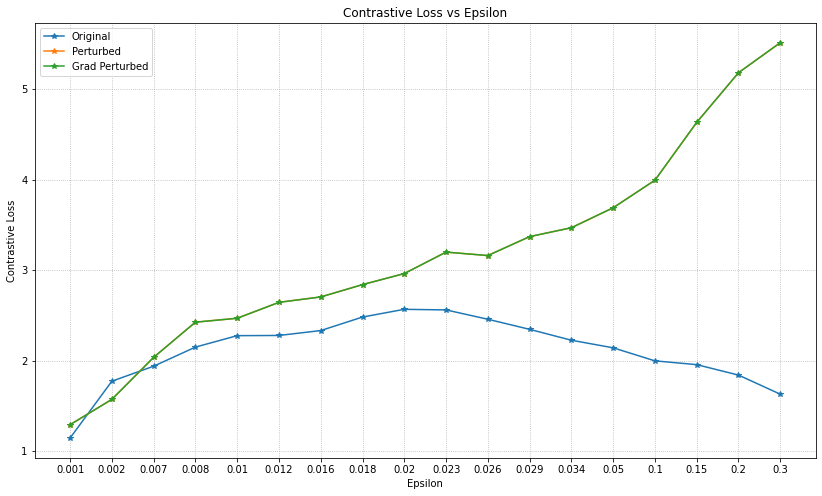

In [30]:
# equally distanced plots
plt.figure(figsize=(14,8))

plt.plot(range(len(epsilons)), og_contrastive_losses, "*-", label='Original')
plt.plot(range(len(epsilons)), perturbed_contrastive_losses, "*-", label='Perturbed')
plt.plot(range(len(epsilons)), grad_perturbed_contrastive_losses, "*-", label='Grad Perturbed')

plt.xticks(range(len(epsilons)), epsilons)
plt.title("Contrastive Loss vs Epsilon")
plt.xlabel("Epsilon")
plt.ylabel("Contrastive Loss")
plt.legend()
plt.grid(linestyle=':')
plt.show()

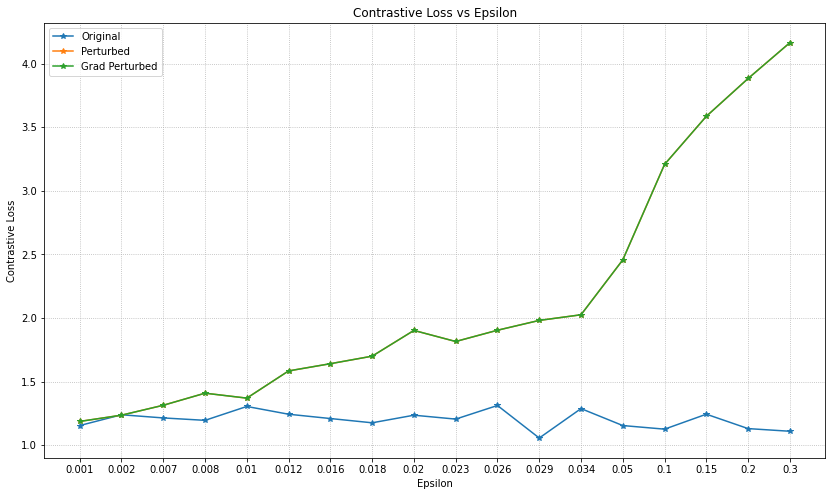

In [30]:
# equally distanced plots
plt.figure(figsize=(14,8))

plt.plot(range(len(epsilons)), og_contrastive_losses, "*-", label='Original')
plt.plot(range(len(epsilons)), perturbed_contrastive_losses, "*-", label='Perturbed')
plt.plot(range(len(epsilons)), grad_perturbed_contrastive_losses, "*-", label='Grad Perturbed')

plt.xticks(range(len(epsilons)), epsilons)
plt.title("Contrastive Loss vs Epsilon")
plt.xlabel("Epsilon")
plt.ylabel("Contrastive Loss")
plt.legend()
plt.grid(linestyle=':')
plt.show()

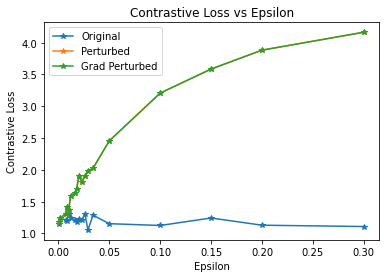

In [31]:
plt.figure()
plt.plot(epsilons, og_contrastive_losses, "*-", label='Original')
plt.plot(epsilons, perturbed_contrastive_losses, "*-", label='Perturbed')
plt.plot(epsilons, grad_perturbed_contrastive_losses, "*-", label='Grad Perturbed')
# plt.yticks(np.arange(0, 1.1, step=0.1))
# plt.xticks(np.arange(0, .35, step=0.05))
plt.title("Contrastive Loss vs Epsilon")
plt.xlabel("Epsilon")
plt.ylabel("Contrastive Loss")
plt.legend()
plt.show()

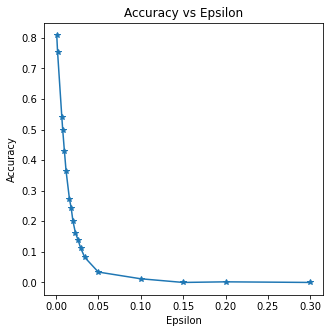

In [32]:
plt.figure(figsize=(5,5))
plt.plot(epsilons, accuracies, "*-")
# plt.yticks(np.arange(0, 1.1, step=0.1))
# plt.xticks(np.arange(0, .35, step=0.05))
plt.title("Accuracy vs Epsilon")
plt.xlabel("Epsilon")
plt.ylabel("Accuracy")
plt.show()

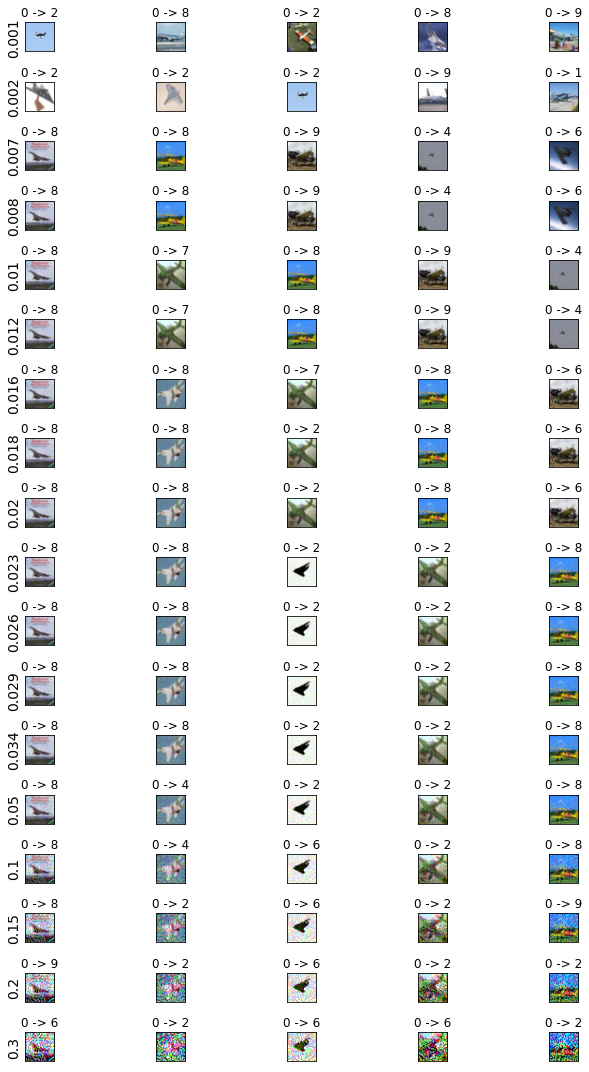

In [33]:
# Plot several examples of adversarial samples at each epsilon
cnt = 0
plt.figure(figsize=(10, 15))
for i in range(len(epsilons)):
    for j in range(len(examples[i])):
        cnt += 1
        plt.subplot(len(epsilons),len(examples[0]),cnt)
        plt.xticks([], [])
        plt.yticks([], [])
        if j == 0:
            plt.ylabel("{}".format(epsilons[i]), fontsize=14) # eps 
        orig,adv,ex = examples[i][j]
        ex = np.moveaxis(ex, 0, -1)
        plt.title("{} -> {}".format(orig, adv))
        plt.imshow(ex, cmap="gray")
plt.tight_layout()
plt.show()

old test below

In [34]:
# def test( classifier, defender, test_loader, epsilon, batch_limit=100):

#     # Accuracy counter
#     correct = 0
#     re_corr = 0
#     adv_examples = []
#     og_contrastive_loss_avg = 0
#     perturbed_contrastive_loss_avg = 0
    
#     classifier = classifier.to(device)
#     defender = defender.to(device)


#     # Loop over all examples in test set
#     for sample in enumerate(tqdm(dataloader_train_moco)):

#         # Send the data and label to the device
#         # data, target = data.to(device), target.to(device)
#         (idx, (data, tfms, target, _)) = sample
        
#         x0, x1 = tfms # transformed image pairs for moco
#         x0 = x0.clone().to(device)
#         x1 = x1.clone().to(device)
        
#         make_tensor = torchvision.transforms.Compose([torchvision.transforms.ToTensor(),])
#         data = make_tensor(data[0]).clone()
#         data = data.to(device).unsqueeze(0) # make batch dim
#         target = target[0].to(device).unsqueeze(0)
        
#         # Set requires_grad attribute of tensor. Important for Attack
#         data.requires_grad = True

#         # Forward pass the data through the model
#         output = classifier(data)
#         init_pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability

#         # If the initial prediction is wrong, dont bother attacking, just move on
#         if init_pred.item() != target.item():
#             continue

#         # Calculate the loss
#         loss = F.nll_loss(output, target)

#         # Zero all existing gradients
#         classifier.zero_grad()

#         # Calculate gradients of model in backward pass
#         loss.backward()

#         # Collect datagrad
#         data_grad = data.grad.data

#         # Call FGSM Attack
#         perturbed_data = fgsm_attack(data, epsilon, data_grad)
        
#         # get perturbed data pairs for moco
#         x0 = custom_tfm(data.squeeze(0)).to(device)
#         x1 = custom_tfm(data.squeeze(0)).to(device)
#         perturbed_x0 = custom_tfm(perturbed_data.squeeze(0).clone()).to(device)
#         perturbed_x1 = custom_tfm(perturbed_data.squeeze(0).clone()).to(device)
        
#         # Re-classify the perturbed image
#         re_output = classifier(data)
#         output = classifier(perturbed_data)
#         print('re-out:', re_output)
#         print('output:', output)
        
#         # fix perturbed image --------------------------------------------------------------
#         x0_grad, x1_grad, og_contrastive_loss = defender.contrastive_loss(x0.unsqueeze(0), x1.unsqueeze(0))
#         perturbed_x0_grad, perturbed_x1_grad, perturbed_contrastive_loss = defender.contrastive_loss(perturbed_x0.unsqueeze(0), perturbed_x1.unsqueeze(0))
#         og_contrastive_loss_avg += og_contrastive_loss
#         perturbed_contrastive_loss_avg += perturbed_contrastive_loss
        
        
#         # also produce x0 and x1 for perturbed data
#         # perturbed = collate_fn.transform(data.detach().cpu().numpy())        

#         # Check for success
#         final_pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability
#         if final_pred.item() == target.item():
#             correct += 1
#             # Special case for saving 0 epsilon examples
#             if (epsilon == 0) and (len(adv_examples) < 5):
#                 adv_ex = perturbed_data.squeeze().detach().cpu().numpy()
#                 adv_examples.append( (init_pred.item(), final_pred.item(), adv_ex) )
#         else:
#             # Save some adv examples for visualization later
#             if len(adv_examples) < 5:
#                 adv_ex = perturbed_data.squeeze().detach().cpu().numpy()
#                 adv_examples.append( (init_pred.item(), final_pred.item(), adv_ex) )
        
#         if idx > batch_limit:
#             break

#     # Calculate final accuracy for this epsilon
#     div = min(float(len(test_loader)), float(batch_limit))
#     final_acc = correct/div
#     og_contrastive_loss_avg = og_contrastive_loss_avg / div
#     perturbed_contrastive_loss_avg = perturbed_contrastive_loss_avg / div
#     print("Epsilon: {}\tTest Accuracy = {} / {} = {}\n og_cont_loss = {} | pert_cont_loss = {}"\
#           .format(epsilon, correct, div, final_acc, og_contrastive_loss_avg, perturbed_contrastive_loss_avg))

#     # Return the accuracy and an adversarial example
#     return final_acc, adv_examples, og_contrastive_loss_avg, perturbed_contrastive_loss_avg, re_acc

In [35]:
        
#         ### safety check ###
        
#         if idx == 50:
#             print('-----------------------------------------------------')
#             # print(data)
#             # print(perturbed_data)
#             print('data and perturbed_data are equal:', torch.equal(data, perturbed_data))
#             print('')
#             print('data grad:', data.grad_fn)
#             print('perturbed grad:', perturbed_data.grad_fn)
#             print('')
#             print('x0.grad:', x0.grad_fn)
#             print('x1_perturbed.grad:', x1_perturbed.grad_fn)
#             print('-----------------------------------------------------')